In [1]:
setwd('/import/DB/fel/BJTC-204')

In [2]:
data = readRDS('all.data.rds') 

In [5]:
library(dplyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [42]:
expr = data[,8:11882] %>%  t() %>%  as.data.frame()

In [43]:
expr[,1:dim(expr)[2]] = 2^expr[,1:dim(expr)[2]] -1

In [45]:
dim(data)

[1]    84 11883

In [46]:
head(expr,2)

,GSM2431804,GSM2432040,GSM2432045,GSM2431943,GSM2431991,GSM2432005,GSM2432041,GSM2431769,GSM2431857,GSM2432016,...,GSM2432036,GSM2432007,GSM2431970,GSM2432037,GSM2431770,GSM2431977,GSM2431867,GSM2431941,GSM2432086,GSM2432052
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NAT2,112.85360,71.14968,45.24166,73.30275,61.87448,85.68567,82.92960,78.83739,90.01884,102.67212,...,78.07012,67.70962,49.18230,62.32515,32.34744,75.63263,40.13312,80.25624,78.68949,77.69861
ADA,71.19336,50.99543,43.91315,53.10876,54.42343,50.69401,54.84417,54.88379,59.40324,62.10522,...,60.99261,58.61107,46.20644,50.46921,48.54976,56.60015,38.22879,57.23091,55.90378,52.03184


In [47]:
group <- 
  data %>% 
  mutate(group = as.factor(ifelse(TYPE =='MDD',
                                   ifelse(death == 0 ,'MDD','MDD-S'),'CON'))) 

In [48]:
control.group = group[,c('GSM','group')]

In [49]:
control.group = control.group %>%tibble::remove_rownames() %>%   tibble::column_to_rownames(.,'GSM')

In [50]:
library(dplyr)

In [51]:
group.all1 = control.group

In [52]:
dataExpr = expr

In [53]:
library(WGCNA)
library(reshape2)
library(stringr)
options(stringsAsFactors = FALSE)
# 打开多线程
enableWGCNAThreads()
#exprMat <- "./fpkm.txt"
type = "unsigned"
corType = "pearson"
corFnc = ifelse(corType=="pearson", cor, bicor)
maxPOutliers = ifelse(corType=="pearson",1,0.05)
robustY = ifelse(corType=="pearson",T,F)

Allowing parallel execution with up to 255 working processes.


In [54]:
m.mad <- apply(dataExpr,1,mad)
dataExprVar <- dataExpr[which(m.mad > 
                 max(quantile(m.mad, probs=seq(0, 1, 0.25))[2],0.01)),]

dataExpr <- as.data.frame(t(dataExprVar))
gsg = goodSamplesGenes(dataExpr, verbose = 3)

 Flagging genes and samples with too many missing values...
  ..step 1


In [55]:
if (!gsg$allOK){
  # Optionally, print the gene and sample names that were removed:
  if (sum(!gsg$goodGenes)>0) 
    printFlush(paste("Removing genes:", 
                     paste(names(dataExpr)[!gsg$goodGenes], collapse = ",")));
  if (sum(!gsg$goodSamples)>0) 
    printFlush(paste("Removing samples:", 
                     paste(rownames(dataExpr)[!gsg$goodSamples], collapse = ",")));
  # Remove the offending genes and samples from the data:
  dataExpr = dataExpr[gsg$goodSamples, gsg$goodGenes]
}


In [56]:
nGenes = ncol(dataExpr)
nSamples = nrow(dataExpr)
dim(dataExpr)

[1]   84 8906

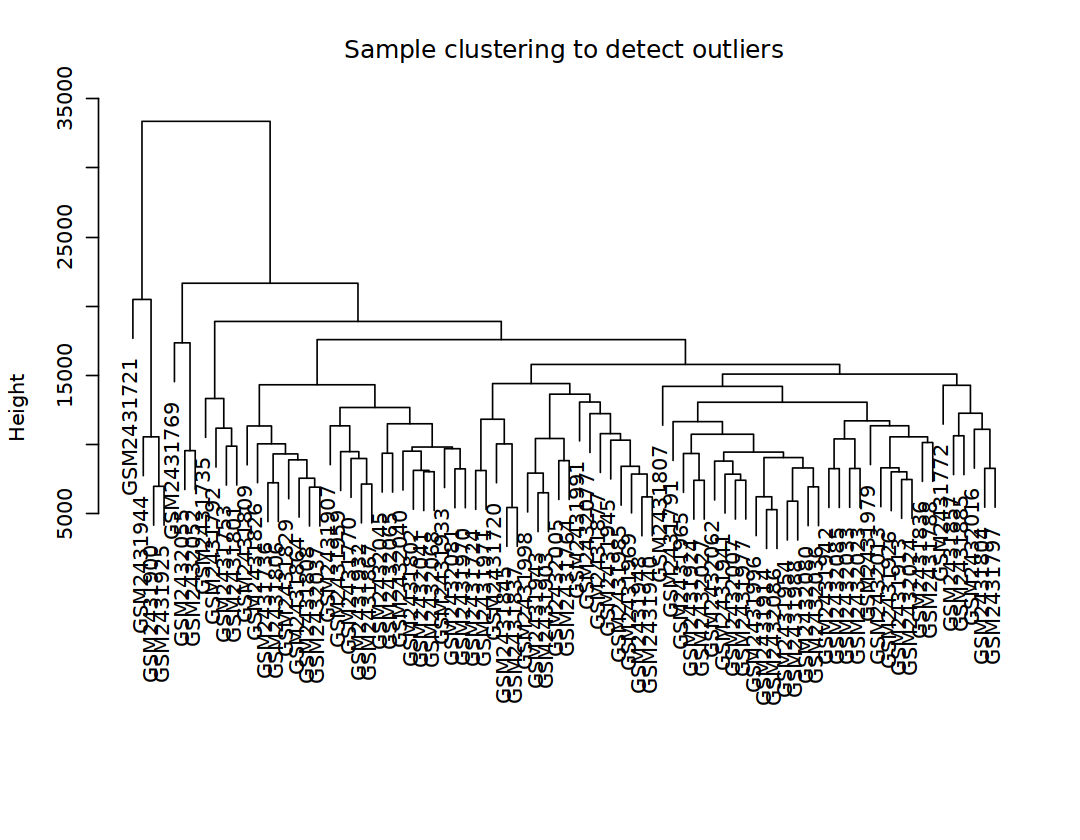

In [57]:
sampleTree = hclust(dist(dataExpr), method = "average")
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="")

In [58]:
powers = c(c(1:10), seq(from = 12, to=30, by=2))
sft = pickSoftThreshold(dataExpr, powerVector=powers, 
                        networkType=type, verbose=5)

pickSoftThreshold: will use block size 5023.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 5023 of 8906
   ..working on genes 5024 through 8906 of 8906
   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k. max.k.
1      1   0.5150  1.480          0.922 2750.000  2.81e+03 4320.0
2      2   0.0209 -0.133          0.737 1210.000  1.18e+03 2600.0
3      3   0.4650 -0.769          0.820  622.000  5.62e+02 1720.0
4      4   0.6170 -1.100          0.865  353.000  2.90e+02 1210.0
5      5   0.6880 -1.280          0.904  213.000  1.58e+02  879.0
6      6   0.7100 -1.430          0.914  135.000  9.01e+01  657.0
7      7   0.7280 -1.530          0.923   89.300  5.34e+01  502.0
8      8   0.7130 -1.660          0.908   60.700  3.28e+01  390.0
9      9   0.7460 -1.690          0.931   42.300  2.06e+01  308.0
10    10   0.7560 -1.740          0.936   30.100  1.33e+01  246.0
11    12   0.8010 -1.770          0.957   16.100  5.92e+00  162.0
12   

In [59]:
options(repr.plot.width = 9)

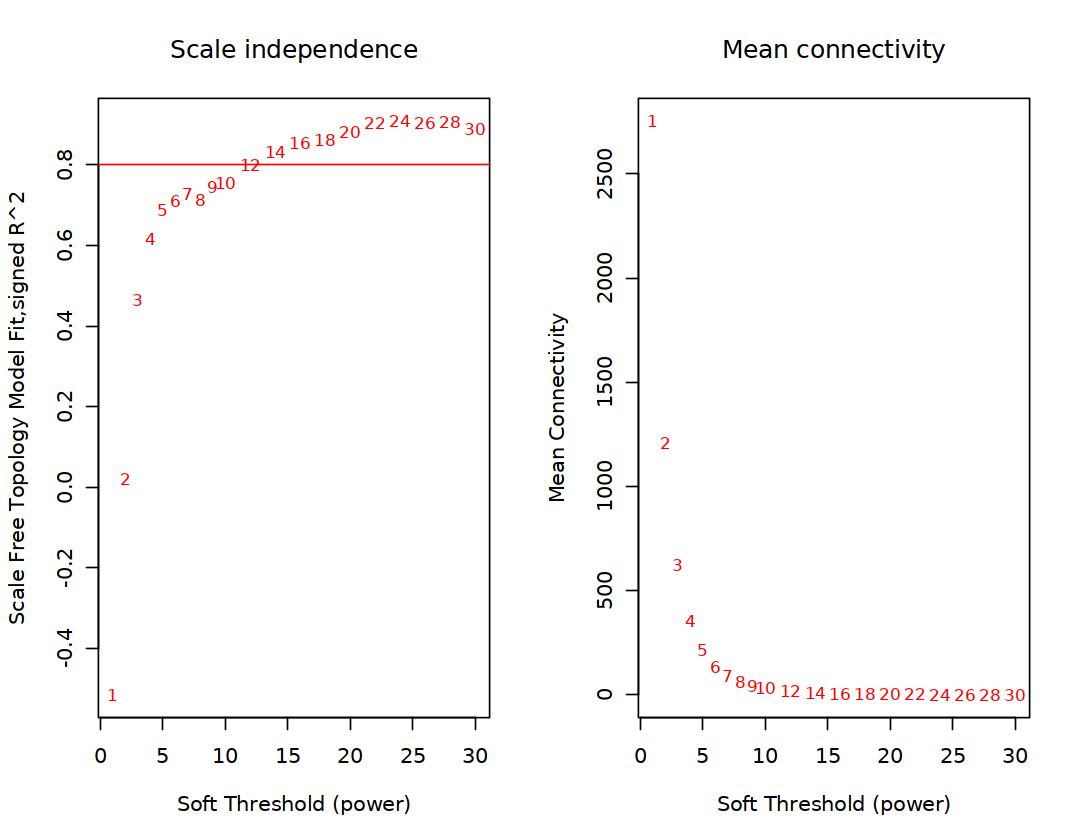

In [60]:
par(mfrow = c(1,2))
cex1 = 0.8
# 横轴是Soft threshold (power)，纵轴是无标度网络的评估参数，数值越高，
# 网络越符合无标度特征 (non-scale)
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
# 筛选标准。R-square=0.85
abline(h=0.8,col="red")
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, 
     cex=cex1, col="red")

In [61]:
power = sft$powerEstimate
power

[1] 16

In [62]:
if (is.na(power)){
  power = ifelse(nSamples<20, ifelse(type == "unsigned", 9, 18),
          ifelse(nSamples<30, ifelse(type == "unsigned", 8, 16),
          ifelse(nSamples<40, ifelse(type == "unsigned", 7, 14),
          ifelse(type == "unsigned", 6, 12))       
          )
          )
}

In [63]:
exprMat='data.txt'

In [64]:
net = blockwiseModules(dataExpr, power = power, maxBlockSize = nGenes,
                       TOMType = type, minModuleSize = 50,
                       reassignThreshold = 0, mergeCutHeight = 0.25,
                       numericLabels = TRUE, pamRespectsDendro = FALSE,
                       saveTOMs=TRUE, corType = corType, 
                       maxPOutliers=maxPOutliers, loadTOMs=TRUE,
                       saveTOMFileBase = paste0(exprMat, ".tom"),
                       verbose = 3)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will use 128 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file data.txt.tom-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
 ..merging modules that are too close..
     mergeCloseModules: Merging modules whose distance is less than 0.25
       Calculating new MEs...


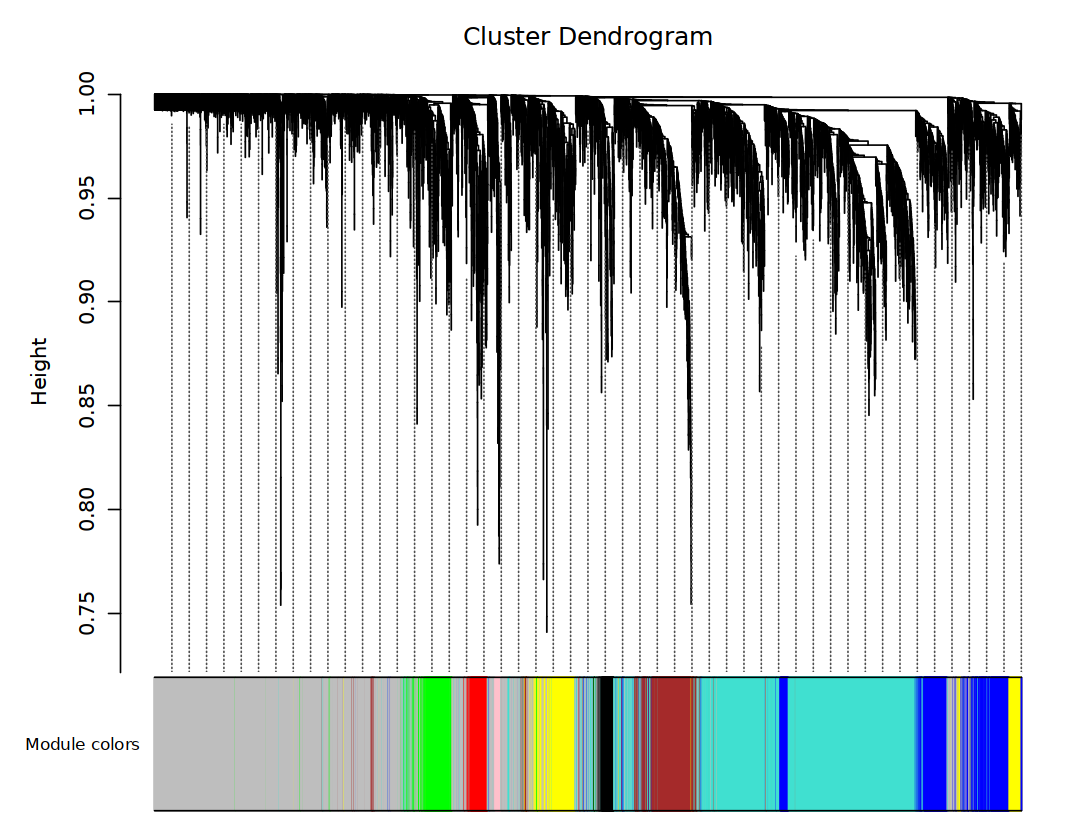

In [65]:
moduleLabels = net$colors
moduleColors = labels2colors(moduleLabels)
plotDendroAndColors(net$dendrograms[[1]], moduleColors[net$blockGenes[[1]]],
                    "Module colors",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

In [66]:
MEs = net$MEs
MEs_col = MEs
colnames(MEs_col) = paste0("ME", labels2colors(
  as.numeric(str_replace_all(colnames(MEs),"ME",""))))
MEs_col = orderMEs(MEs_col)

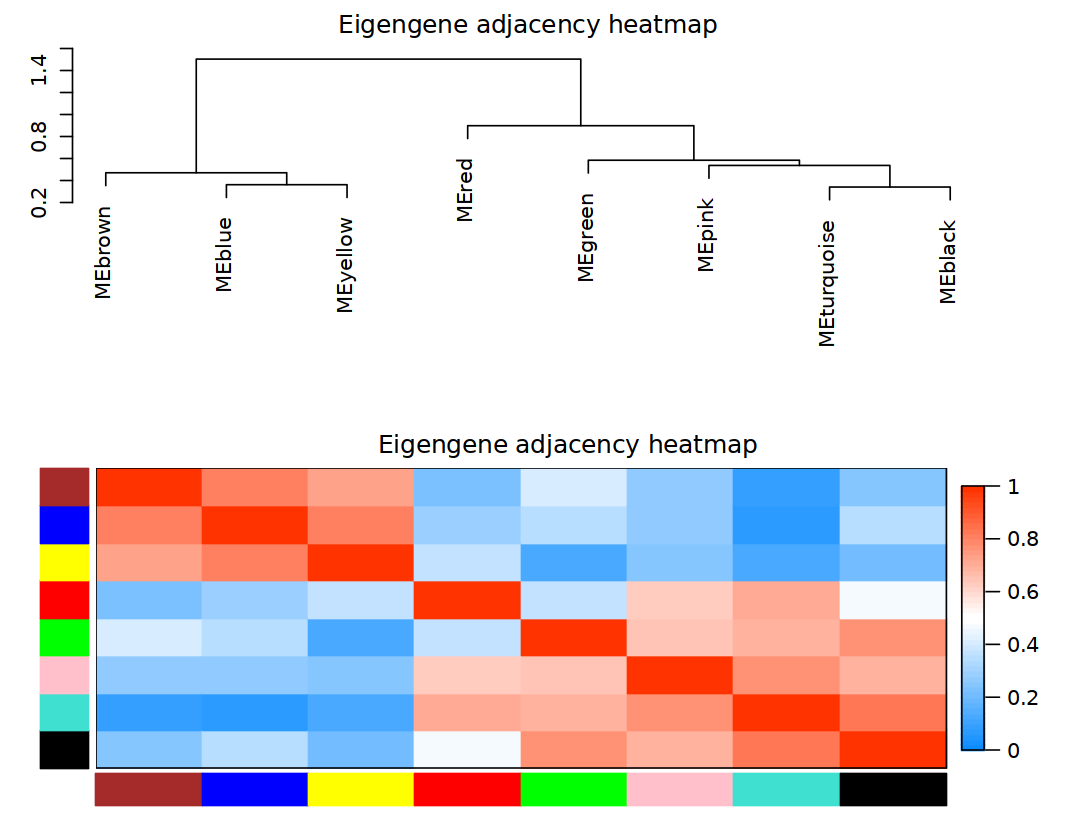

In [67]:
plotEigengeneNetworks(MEs_col, "Eigengene adjacency heatmap", 
                      marDendro = c(3,3,2,4),
                      marHeatmap = c(3,4,2,2), plotDendrograms = T, 
                      xLabelsAngle = 90)

In [68]:
TOM = TOMsimilarityFromExpr(dataExpr, power=power, corType=corType, networkType=type)

TOM calculation: adjacency..
..will use 128 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [69]:
group.all1  = group.all1 %>%  tibble::rownames_to_column(.,'sample')

In [70]:
group.all1$group = as.character(group.all1$group )

In [71]:
design <- model.matrix(~0 + group.all1$group)


In [72]:
dimnames(design) <- list(group.all1$sample, sort(unique(group.all1$group)))


In [73]:

design <- design[rownames(MEs_col),]
# 计算 pearson 相关性和显著性
modTraitCor <- cor(MEs_col, design, use = "p")
modTraitP <- corPvalueStudent(modTraitCor, dim(group.all1)[1])

In [74]:
modTraitCorP = bicorAndPvalue(MEs_col, design)
modTraitCor = modTraitCorP$bicor
modTraitP   = modTraitCorP$p

Warning message in bicor(x, y, use = use, ...):
"bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD."


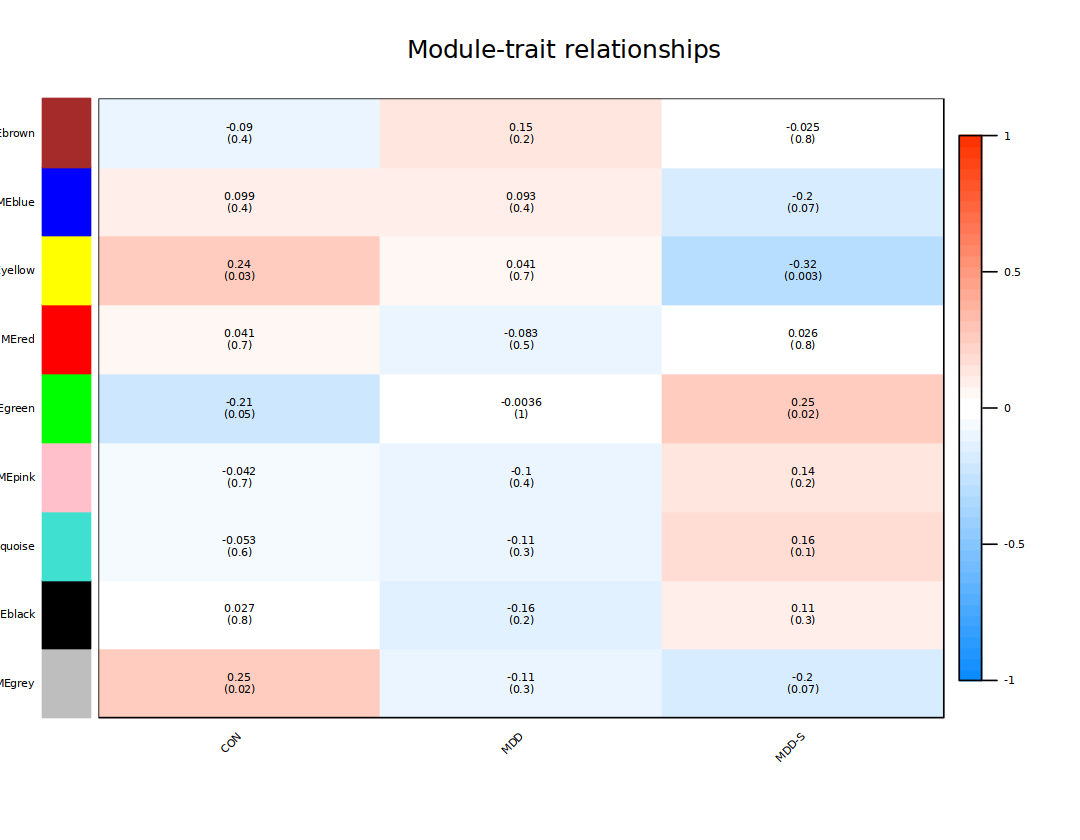

In [75]:
textMatrix <- paste0(signif(modTraitCor, 2), "\n(", signif(modTraitP, 1), ")")
dim(textMatrix) <- dim(modTraitCor)
labeledHeatmap(
  Matrix = modTraitCor,
  xLabels = colnames(design),
  yLabels = colnames(MEs_col),
  cex.lab = 0.5,
  ySymbols = colnames(MEs_col),
  colorLabels = FALSE,
  colors = blueWhiteRed(50),
  textMatrix = textMatrix,
  setStdMargins = FALSE,
  cex.text = 0.5,
  zlim = c(-1, 1),
  main = paste("Module-trait relationships")
)

In [ ]:
dat = dataExpr

In [ ]:
nSamples <- nrow(dat)
#计算MM值和GS值
modNames <- substring(colnames(MEs_col), 3) ##切割，从第三个字符开始保存
geneModuleMembership <- as.data.frame(cor(dat, MEs, use = "p")) #算出每个模块跟基因的Pearson相关系数矩阵
MMPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples)) #计算MM值对应的P值
names(geneModuleMembership) <- paste("MM", modNames, sep="")
names(MMPvalue) <- paste("p.MM", modNames, sep="")
geneTraitSignificance <- as.data.frame(cor(dat, design, use = "p")) 

In [ ]:
GSPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples))
names(geneTraitSignificance) <- paste("GS.", colnames(design), sep="")
names(GSPvalue) <- paste("p.GS.", colnames(design), sep="")

In [ ]:
module <- "yellow"
column <- match(module, modNames)  ##在所有模块中匹配选择的模块，返回所在的位置
brown_moduleGenes <- names(net$colors)[which(moduleColors == module)]
MM <- abs(geneModuleMembership[brown_moduleGenes, column])
GS <- abs(geneTraitSignificance[brown_moduleGenes, 1])

In [ ]:
verboseScatterplot(
  MM, GS,
  xlab = paste("Module Membership in", module, "module"),
  ylab = "Gene significance for proliferating",
  main = paste("Module membership vs. gene significance\n"),
  abline = TRUE,
  pch = 21,
  cex.main = 1.2,
  cex.lab = 1.2,
  cex.axis = 1.2,
  col = "black",
  bg = module
)

In [ ]:
verboseScatterplot(MM, GS,
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene significance for Basal",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)
abline(h=0.3,v=0.8,col="red",lwd=1.5)

In [ ]:
brown_hub <- brown_moduleGenes[(GS > 0.3 & MM > 0.8)]
length(brown_hub)

In [ ]:
write.csv(brown_hub,'brown_hub_gene.csv')

In [ ]:
library(clusterProfiler)
library(org.Hs.eg.db)
options(stringsAsFactors = F)
 
brown_hub_gene <- read.csv('brown_hub_gene.csv',header = F)
brown_hub_gene <- brown_hub_gene[-1,]
brown_hub_gene <- brown_hub_gene[,-1]
gene=unique(brown_hub_gene)
##基因转ID
sig_DP_entrezId <- mapIds(x = org.Hs.eg.db,
                             keys = gene,
                             keytype = "SYMBOL",
                             column = "ENTREZID")


In [ ]:
table(is.na(sig_DP_entrezId))

In [ ]:

sig_DP_entrezId <- na.omit(sig_DP_entrezId)
go_bp <- enrichGO(gene = sig_DP_entrezId,
                      OrgDb = org.Hs.eg.db,
                      keyType = "ENTREZID",
                      ont = "ALL",
                      pvalueCutoff = 0.05,
                      qvalueCutoff = 1,
                      readable = TRUE)


In [ ]:
#画图
dotplot(go_bp)

In [ ]:
ek <- enrichKEGG(gene =sig_DP_entrezId , 
                   organism = "hsa",  
                   pvalueCutoff =1, 
                   qvalueCutoff = 1) 
    keggres = ek@result
    #write.csv(keggres,file = 'kegg_results.csv')
    enrichplot::dotplot(ek,  
            x = "GeneRatio", 
            color = "p.adjust", 
            showCategory = 15, 
            size = 'Count', 
            title = "KEGG_enrichment_dotplot"  
            )
    #ggsave('KEGG_enrichment_dotplot.pdf',height = 6,width = 6)
    KEGG2 <- pairwise_termsim(ek)
    emapplot(KEGG2, cex_label_category=.8, cex_line=.5,showCategory = 15) + 
      ggplot2::scale_fill_continuous(low = "#e06663", high = "#327eba", name = "p.adjust",
                            guide = ggplot2::guide_colorbar(reverse = TRUE, order=2.5), trans='log10')
    #ggsave('KEGG_enrichment_net.pdf',height = 8,width = 8)   